In [1]:
## Cullan's code: only using Pgg info
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, Fish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

if __name__ == "__main__":

    configpath = os.path.join(parent, "test.ini")
    pardict = ConfigObj(configpath)

    # resolve inputfile relative to the ini file location
    ini_dir = os.path.dirname(configpath)
    inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
    pardict["inputfile"] = os.path.abspath(inputfile_path)

    #pardict = ConfigObj(configpath)

    # Read in the file containing the redshift bins, nz and bias values
    data = InputData(pardict)

    # Set up the linear power spectrum and derived parameters based on the input cosmology
    cosmo = CosmoResults(pardict, data.zmin, data.zmax)
    if np.any(data.volume > 0):
        cosmo.volume = data.volume * 1.0e9

    # Convert the nz to nbar in (h/Mpc)^3
    data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

    # Scales the bias so that it goes as b/G(z)
    if pardict.as_bool("scale_bias"):
        data.scale_bias(cosmo.growth)
    print("#  Data nbar")
    print(data.nbar, data.nbarz)
    print("#  Data bias")
    print(data.bias)

    # Precompute some things we might need for the Fisher matrix
    recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
    print("#  Data recon factor")
    print(recon)

    # Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
    identity = np.eye(len(data.nbar) + 3)
    print(
        "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
    )
    erralpha = np.zeros(len(cosmo.z))
    FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
    for iz in range(len(cosmo.z)):

        if np.any(data.nz[:, iz] > 1.0e-30):

            Catch = Fish(
                cosmo,
                cosmo.kmin,
                cosmo.kmax,
                data,
                iz,
                recon[iz],
                derPalpha,
                pardict.as_bool("BAO_only"),
                pardict.as_bool("GoFast"),
            )

            # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
            ExtraCatch = Fish(
                cosmo,
                cosmo.kmax,
                0.5,
                data,
                iz,
                recon[iz],
                derPalpha_BAO_only,
                True,
                pardict.as_bool("GoFast"),
            )
            Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

            # Add the Fisher matrix to the full fisher matrix
            FullCatch[
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            ] += Catch[: len(data.nbar), : len(data.nbar)]
            FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
            FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
            FullCatch[-3:, -3:] += Catch[-3:, -3:]

            # Invert the Fisher matrix to get the parameter covariance matrix
            cov = dgesv(Catch, identity)[2]

            # Compute the error on isotropic alpha also
            J = np.array([2.0 / 3.0, 1.0 / 3.0])
            erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

            # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
            means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
            cov_renorm = CovRenorm(cov, means)

            # Print the parameter means and errors
            errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
            print(
                " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
                #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
            )

            # Output the fisher matrix for the redshift bin
            write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

        else:
            erralpha[iz] = 1.0e30
            print(
                " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
            )

    # Run the cosmological parameters at the centre of the combined redshift bin
    identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
    cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

    # Invert the Combined Fisher matrix to get the parameter
    # covariance matrix and compute means and errors
    cov = dgesv(FullCatch, identity)[2]
    J = np.array([2.0 / 3.0, 1.0 / 3.0])
    erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
    means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
    cov_renorm = CovRenorm(cov, means)
    errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
    print("#  Combined errors")
    print("#=================")
    print(
        " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
            cosmo.z[0],
            cosmo.volume[0] / 1e9,
            means[0],
            errs[0],
            means[1],
            errs[1],
            means[2],
            errs[2],
            erralpha,
        )
    )
FullCatch1=FullCatch
# using BAO_ONLY=TRUE: changes results!!!
# convert number/ sqdeg/redshift bin, create new data.txt
# 10 -3 should be seeing.

/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04564746 0.04575759 0.04577883 0.04578938 0.04579628 0.04580104
  0.04580406 0.04580779 0.0458125  0.04581645]] [[0.04527934 0.01505812 0.01715227 0.01143712 0.00706725 0.00475426
  0.00361208 0.00306735 0.00239827 0.00174144]]
#  Data bias
[[1.34353032 1.3506268  1.35777063 1.36496127 1.37219819 1.37948082
  1.38680864 1.39418108 1.40159762 1.40905771]]
#  Data recon factor
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
 0.005    0.0000     0.430       990.19         22.1       206.78        67.5       430.55       153.275
 0.015    0.0003     0.432       373.72         65.5       78.19        67.8       163.02       58.001
 0.025    0.0007     0.435       226.67         107.9       47.50        68.2       99.18       35.264
 0.035    0.0014     0.437       162.37         149.2       34.08        68.5       71.24       25.316
 0.045    0.0022     0.440       126.44        

In [2]:
#My code: using all three power spectra
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, newFish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

if __name__ == "__main__":


    configpath = os.path.join(parent, "test.ini")
    pardict = ConfigObj(configpath)

    # resolve inputfile relative to the ini file location
    ini_dir = os.path.dirname(configpath)
    inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
    pardict["inputfile"] = os.path.abspath(inputfile_path)

    #pardict = ConfigObj(configpath)

    # Read in the file containing the redshift bins, nz and bias values
    data = InputData(pardict)

    # Set up the linear power spectrum and derived parameters based on the input cosmology
    cosmo = CosmoResults(pardict, data.zmin, data.zmax)
    if np.any(data.volume > 0):
        cosmo.volume = data.volume * 1.0e9

    # Convert the nz to nbar in (h/Mpc)^3
    data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

    # Scales the bias so that it goes as b/G(z)
    if pardict.as_bool("scale_bias"):
        data.scale_bias(cosmo.growth)
    print("#  Data nbar")
    print(data.nbar, data.nbarz)
    print("#  Data bias")
    print(data.bias)

    # Precompute some things we might need for the Fisher matrix
    recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
    print("#  Data recon factor")
    print(recon)

    # Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
    identity = np.eye(len(data.nbar) + 3)
    print(
        "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
    )
    erralpha = np.zeros(len(cosmo.z))
    FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
    for iz in range(len(cosmo.z)):

        if np.any(data.nz[:, iz] > 1.0e-30):

            Catch = newFish(
                cosmo,
                cosmo.kmin,
                cosmo.kmax,
                data,
                iz,
                recon[iz],
                derPalpha,
                pardict.as_bool("BAO_only"),
            )

            # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
            ExtraCatch = newFish(
                cosmo,
                cosmo.kmax,
                0.5,
                data,
                iz,
                recon[iz],
                derPalpha_BAO_only,
                True,
            )
            Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

            # Add the Fisher matrix to the full fisher matrix
            FullCatch[
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            ] += Catch[: len(data.nbar), : len(data.nbar)]
            FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
            FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
            FullCatch[-3:, -3:] += Catch[-3:, -3:]

            # Invert the Fisher matrix to get the parameter covariance matrix
            cov = dgesv(Catch, identity)[2]

            # Compute the error on isotropic alpha also
            J = np.array([2.0 / 3.0, 1.0 / 3.0])
            erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

            # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
            means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
            cov_renorm = CovRenorm(cov, means)

            # Print the parameter means and errors
            errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
            print(
                " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
                #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
            )

            # Output the fisher matrix for the redshift bin
            write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

        else:
            erralpha[iz] = 1.0e30
            print(
                " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
            )

    # Run the cosmological parameters at the centre of the combined redshift bin
    identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
    cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

    # Invert the Combined Fisher matrix to get the parameter
    # covariance matrix and compute means and errors
    cov = dgesv(FullCatch, identity)[2]
    J = np.array([2.0 / 3.0, 1.0 / 3.0])
    erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
    means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
    cov_renorm = CovRenorm(cov, means)
    errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
    print("#  Combined errors")
    print("#=================")
    print(
        " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
            cosmo.z[0],
            cosmo.volume[0] / 1e9,
            means[0],
            errs[0],
            means[1],
            errs[1],
            means[2],
            errs[2],
            erralpha,
        )
    )
# using BAO_ONLY=TRUE: changes results!!!\
# plot changes and see if it fits the data
# integral for mu is -1 to 1

/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04564746 0.04575759 0.04577883 0.04578938 0.04579628 0.04580104
  0.04580406 0.04580779 0.0458125  0.04581645]] [[0.04527934 0.01505812 0.01715227 0.01143712 0.00706725 0.00475426
  0.00361208 0.00306735 0.00239827 0.00174144]]
#  Data bias
[[1.34353032 1.3506268  1.35777063 1.36496127 1.37219819 1.37948082
  1.38680864 1.39418108 1.40159762 1.40905771]]
#  Data recon factor
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
 0.005    0.0000     0.430       95.50         22.1       3.76        67.5       2.53       2.159
 0.015    0.0003     0.432       37.61         65.5       18.14        67.8       10.05       10.560
 0.025    0.0007     0.435       24.01         107.9       21.64        68.2       12.87       12.660
 0.035    0.0014     0.437       19.56         149.2       26.21        68.5       21.81       15.707
 0.045    0.0022     0.440       18.97         189.6      

In [5]:
from TackleBox import get_powerfx, get_inv_cov,get_inv_cov_un, compute_inv_cov,get_full_deriv,compute_deriv_alphas
from scipy.interpolate import splrep, splev
kvec = np.linspace(cosmo.kmin,cosmo.kmax,400)
muvec = np.linspace(-1,1,200)
pgg=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgg at each k and mu value
pgu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgu at each k and mu value
puu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of puu at each k and mu value
cov=np.zeros((3,3,len(kvec),len(muvec))) # covariance info, 3x3 for Pgg Pgu Puu and then k and mu
invcov=np.zeros((3,3,len(kvec),len(muvec))) # inverse covariance info
bder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt b at each k and mu value
fder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt f at each k and mu value
aperder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt aperp at each k and mu value
aparder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt apara at each k and mu value

In [6]:
pkval = splev(kvec, cosmo.pk[0])
pksmoothval = splev(kvec, cosmo.pksmooth[0])
npop = np.shape(data.nbar)[0]
npk = int(npop*(npop+1)/2)
coords = [[kval, muval] for kval in kvec for muval in muvec]
kaiser = np.tile(data.bias[:, 0], (len(muvec), 1)).T + cosmo.f[0] * muvec ** 2
derPalpha = compute_deriv_alphas(cosmo,BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = np.array([
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[0] / cosmo.sigma8[0]) ** 2
for i in range(2)])

In [7]:
print(npk,npop)

1 1


In [32]:
fval,zval,hval,nbarval,vbarval,pverr,vol,dk,da,sigmaval=cosmo.f[0],cosmo.z[0],cosmo.h[0],data.nbar[0,0],data.nbarz[0,0],data.pverr[0,0],cosmo.volume[0],kvec[1]-kvec[0],cosmo.da[0],cosmo.sigma8[0]
# adjust power spectra # spline interp # also plotting monopole # instead of choosing mu, integrate over mu w no weighting
# take pgg ij integrate over mu to get pgg i then pass that into cov matrix
for i, kval in enumerate(kvec):
    for j, muval in enumerate(muvec):
        pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[:,j],fval,zval,hval)
        cov[:,:,i,j],invcov[:,:,i,j]=get_inv_cov(pgg[i,j],pgu[i,j],puu[i,j],nbarval,vbarval,pverr,kval,vol,da,hval,dk)
        info=get_full_deriv(kval,muval,pkval[i],pksmoothval[i],kaiser[:,j],fval,zval,hval,derPalphaval[:,i,j],sigmaval) # then multiply by Dfactor**2 -> same for 4, different for power spec, make them the same for now.
        bder[:,i,j],fder[:,i,j],aperder[:,i,j],aparder[:,i,j]=info[:,0],info[:,1],info[:,2],info[:,3]

/tmp/ipykernel_19861/3545009298.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[:,j],fval,zval,hval)


In [19]:
print(nbarval,vbarval)

168.5093854360394 171.0424982941841


/tmp/ipykernel_19861/3237476887.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  results1=scipy.integrate.simps(pgg,muvec,axis=1)
/tmp/ipykernel_19861/3237476887.py:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  results2=scipy.integrate.simps(pgu,muvec,axis=1)
/tmp/ipykernel_19861/3237476887.py:4: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  results3=scipy.integrate.simps(puu,muvec,axis=1)


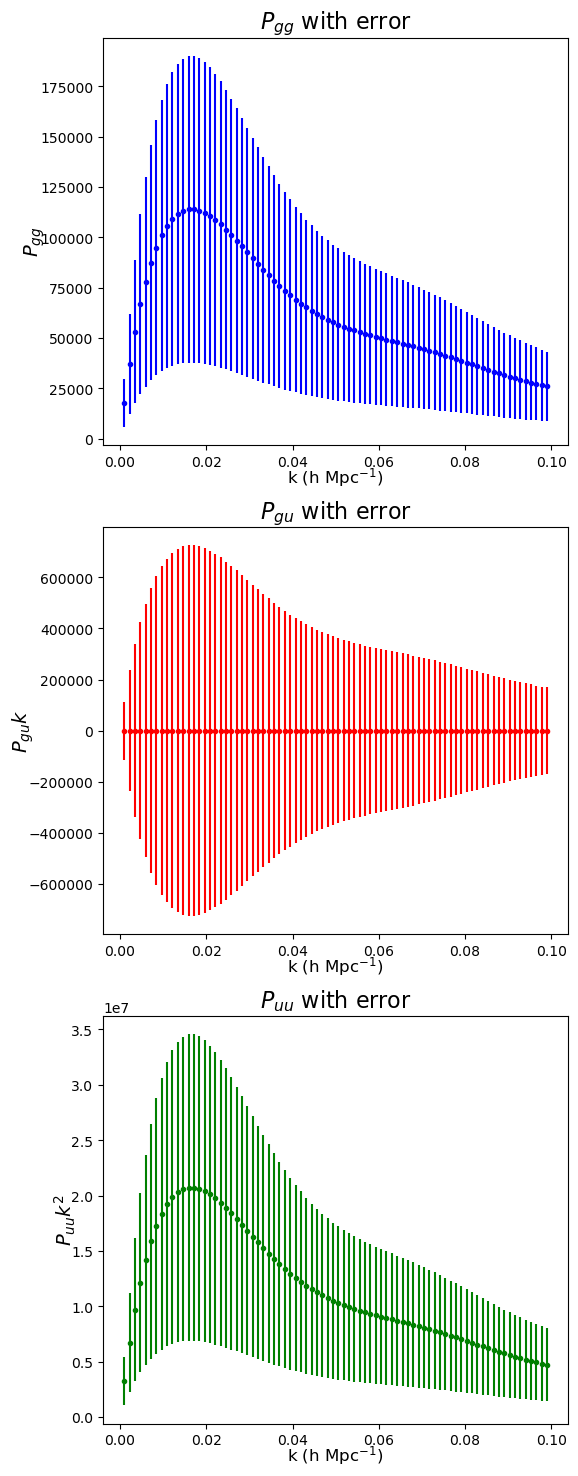

In [33]:
import scipy.integrate
results1=scipy.integrate.simps(pgg,muvec,axis=1)
results2=scipy.integrate.simps(pgu,muvec,axis=1)
results3=scipy.integrate.simps(puu,muvec,axis=1)
import matplotlib.pyplot as plt
fig,axes=plt.subplots(3,1,figsize=(6,18))
axes.flatten()
factor=(2*np.pi**2)/(vol*kval**2*(kvec[1]-kvec[0]))
ps=pverr*da*hval
cgg=factor*2*(results1+1/nbarval)**2
cgu=factor*(results1+1/nbarval)*(results3+ps**2/vbarval)+results2**2
cuu=factor*2*(results3+ps**2/vbarval)**2
#axes[0].errorbar(kvec[::5],(results1*kvec)[::5],yerr=(np.sqrt(cgg)*kvec)[::5],fmt='.',color='b')
axes[0].errorbar(kvec[::5],results1[::5],yerr=np.sqrt(cgg)[::5],fmt='.',color='b')
axes[1].errorbar(kvec[::5],(results2*kvec)[::5],yerr=(np.sqrt(cgu)*kvec)[::5],fmt='.',color='r')
axes[2].errorbar(kvec[::5],(results3*kvec**2)[::5],yerr=(np.sqrt(cuu)*kvec**2)[::5],fmt='.',color='g')
#axes[0].plot(kvec,results1,color='b')
#axes[1].plot(kvec,results2*kvec,color='r')
#axes[2].plot(kvec,results3*kvec**2,color='g')
axes[0].set_title('$P_{gg}$ with error',fontsize=16)
axes[1].set_title('$P_{gu}$ with error',fontsize=16)
axes[2].set_title('$P_{uu}$ with error',fontsize=16)
axes[0].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[1].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[2].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[0].set_ylabel('$P_{gg}$',fontsize=14,labelpad=-5)
axes[1].set_ylabel('$P_{gu}k$',fontsize=14,labelpad=-5)
axes[2].set_ylabel('$P_{uu}k^2$',fontsize=14,labelpad=-5)
path = '../Figures/FinalPower.png'
plt.show()
#plt.savefig(path, dpi=300,bbox_inches='tight')
#plt.close()

# number/sq degree /width of bin

In [ ]:

plt.plot(pgg,)

[ 8871.32556905 10891.83414886 12850.92860246 14749.23428713
 16587.40625021 18366.24746123 20086.73578832 21750.02022986
 23357.35686688 24910.07341083 26409.53924846 27857.1221987
 29254.19446921 30602.12792129 31902.25178431 33155.88830278
 34364.352765   35528.87640682 36650.56190618 37730.61488303
 38770.40807105 39771.17681947 40733.65147301 41658.49159913
 42546.54820857 43398.83385953 44216.36139229 45000.13974229
 45751.16668957 46470.41136148 47158.70385472 47816.79411634
 48445.43185294 49045.33860977 49617.1908959  50161.66318293
 50679.42877256 51171.13604096 51637.41386896 52078.88996908
 52496.18894926 52889.90880995 53260.62051888 53608.89261694
 53935.29127174 54240.37079933 54524.64124978 54788.59973721
 55032.7429119  55257.56590917 55463.55667633 55651.17649759
 55820.87779664 55973.11156171 56108.32655711 56226.96834573
 56329.46705589 56416.23388792 56487.67684748 56544.20137543
 56586.20980948 56614.10084409 56628.26361529 56629.07331255
 56616.90072093 56592.112

In [ ]:
#print(factor[::5])
#print(factor[::5]/dk)
print(dk,vol)
print(cosmo.volume)

0.0002481203007518797 35605260.67116556
[35605260.67116556]


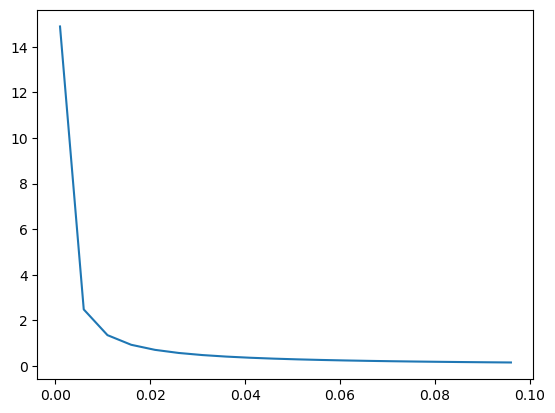

In [ ]:

#plt.plot(kvec,(np.sqrt(cov[2,2,:,p])/puu[:,p]))
#plt.show()
plt.plot(newkvec,(np.sqrt(cov[0,0,:,p]))/pgg[:,p])
plt.show()

In [81]:
newbder=scipy.integrate.simps(bder,muvec,axis=2)
newfder=scipy.integrate.simps(fder,muvec,axis=2)
newapder=scipy.integrate.simps(aperder,muvec,axis=2)
newalder=scipy.integrate.simps(aparder,muvec,axis=2)
fig,axes=plt.subplots(3,1,figsize=(6,18))
axes.flatten()
axes[0].plot(kvec,newbder[0,:]/results1,label='b$\sigma_8$')
axes[0].plot(kvec,newfder[0,:]/results1,label='f$\sigma_8$',linestyle='--')
axes[0].plot(kvec,newapder[0,:]/results1,label='$\\alpha_{\perp}$')
axes[0].plot(kvec,newalder[0,:]/results1,label='$\\alpha_{\parallel}$',linestyle='--')
axes[0].set_ylabel('$\\frac{1}{P_{gg}}$ $\\frac{dP_{gg}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[0].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[0].set_title('Derivatives of $P_{{gg}}$',fontsize=16)
axes[0].legend()
axes[1].plot(kvec,newbder[1,:]/results2,label='b$\sigma_8$')
axes[1].plot(kvec,newfder[1,:]/results2,label='f$\sigma_8$',linestyle='--')
axes[1].plot(kvec,newapder[1,:]/results2,label='$\\alpha_{\perp}$')
axes[1].plot(kvec,newalder[1,:]/results2,label='$\\alpha_{\parallel}$',linestyle='--')
axes[1].set_ylabel('$\\frac{1}{P_{gu}}$ $\\frac{dP_{gu}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[1].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[1].set_title('Derivatives of $P_{{gu}}$',fontsize=16)
axes[1].legend()
axes[2].plot(kvec,newbder[2,:]/results3,label='b$\sigma_8$')
axes[2].plot(kvec,newfder[2,:]/results3,label='f$\sigma_8$',linestyle='--')
axes[2].plot(kvec,newapder[2,:]/results3,label='$\\alpha_{\perp}$')
axes[2].plot(kvec,newalder[2,:]/results3,label='$\\alpha_{\parallel}$',linestyle='--')
axes[2].set_ylabel('$\\frac{1}{P_{uu}}$ $\\frac{dP_{uu}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[2].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[2].set_title('Derivatives of $P_{{uu}}$',fontsize=16)
axes[2].legend()
path = '../Figures/FinalDerivatives.png'
plt.savefig(path, dpi=300,bbox_inches='tight')
plt.close()

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape 

In [ ]:
for i in range(100):
    plt.errorbar(kvec[::5],(pgu[:,i]*kvec)[::5],yerr=(np.sqrt(cov[1,1,:,i])*kvec)[::5])
    plt.title('P$_{{gu}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))
    plt.ylabel('$P_{gu}k$')
    plt.xlabel('k (h Mpc$^{-1})$')
    plt.ylim(-10000,3.5e7)
    path = '../../Data/Pgu/{:03d}.png'.format(i)
    plt.savefig(path, dpi=300)
    plt.close()

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_419332/788185335.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title('P$_{{gu}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))


In [ ]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Pgu"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Pgu moving errorbars.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)